In [1]:
import librosa
import pandas as pd
import torch
import torch.nn as nn
import glob
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import random
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
audio_dir = sorted(glob.glob("DEAM_Dataset/DEAM_audio/MEMD_audio/*.mp3", recursive=True))

In [3]:
def get_song_level_predictions():

    anno_1_2000 = pd.read_csv("DEAM_Dataset/DEAM_Annotations/annotations/annotations averaged per song/song_level/static_annotations_averaged_songs_1_2000.csv")
    anno_2001_2058 = pd.read_csv("DEAM_Dataset/DEAM_Annotations/annotations/annotations averaged per song/song_level/static_annotations_averaged_songs_2000_2058.csv")

    annotations = pd.concat([anno_1_2000, anno_2001_2058])
    
    annotations = annotations.rename(columns={column: column.replace(" ", "") for column in annotations.columns})

    annotations['song_id'] = annotations['song_id'].astype(str)
    annotations = annotations.drop(columns=[column for column in annotations.columns if column not in ["song_id", "valence_mean", "arousal_mean"]])
    annotations['valence_mean'] = ((annotations['valence_mean'] - 1) / (9 - 1)) * (1 - (-1)) + (-1)
    annotations['arousal_mean'] = ((annotations['arousal_mean'] - 1) / (9 - 1)) * (1 - (-1)) + (-1)

    return annotations

In [4]:
def get_mfcc_from_audio(file):

    y, sr = librosa.load(file)

    mfcc_matrix = librosa.feature.mfcc(
        y=y,
        sr=sr,
        n_mfcc=20
    )

    mfcc_matrix = torch.tensor(mfcc_matrix, dtype=torch.float32)
    mean = mfcc_matrix.mean(dim=1)
    std = mfcc_matrix.std(dim=1)
    min_ = mfcc_matrix.min(dim=1).values
    max_ = mfcc_matrix.max(dim=1).values
    X = torch.cat([mean, std, min_, max_], dim = 0)

    return X

In [5]:
def get_cens_from_audio(file):
    y, sr = librosa.load(file)

    chroma_matrix = librosa.feature.chroma_cens(
        y=y,
        sr=sr,
        n_chroma=12
    )

    chroma_matrix = torch.tensor(chroma_matrix, dtype=torch.float32)
    mean = chroma_matrix.mean(dim=1)
    std = chroma_matrix.std(dim=1)
    min_ = chroma_matrix.min(dim=1).values
    max_ = chroma_matrix.max(dim=1).values
    X = torch.cat([mean, std, min_, max_], dim = 0)

    return X



In [6]:
def create_mfcc_tensor():

    audio_dir = sorted(glob.glob("DEAM_Dataset/DEAM_audio/MEMD_audio/*.mp3", recursive=True))
    X = []

    for song in tqdm(audio_dir, total=len(audio_dir)):
        mfcc_tensor = get_mfcc_from_audio(song)
        reshaped = mfcc_tensor.view(1, -1)
        X.append(reshaped)
    
    X = torch.stack(X)
    return X

In [7]:
def create_dual_feature_tensor():

    audio_dir = sorted(glob.glob("DEAM_Dataset/DEAM_audio/MEMD_audio/*.mp3", recursive=True))
    
    X = []

    for song in tqdm(audio_dir, total=len(audio_dir)):
        mfcc_tensor = get_mfcc_from_audio(song)
        cens_tensor = get_cens_from_audio(song)
        reshaped = torch.cat([mfcc_tensor, cens_tensor], dim=0)
        X.append(reshaped)
    
    X = torch.stack(X)
    return X

In [8]:
def create_label_tensor(annotations_df):
    valence = annotations_df['valence_mean'].to_numpy().astype(np.float32)
    valence = torch.from_numpy(valence).view(-1,1)

    arousal = annotations_df['arousal_mean'].to_numpy().astype(np.float32)
    arousal = torch.from_numpy(arousal).view(-1,1)

    return torch.concat((valence, arousal), dim=1)

In [9]:
def check_dataset_creation(annotations_df, songs):

    for (_, row), song in zip(annotations_df.iterrows(), songs):
        assert row["song_id"] == song[song.rindex("/") + 1: song.index(".")]
        assert row["valence_mean"] > -1 and row["valence_mean"] < 1
        assert row["arousal_mean"] > -1 and row["arousal_mean"] < 1

In [10]:
class EmotionRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.net(x)

In [11]:
def concordance_cc(y_pred, y_true):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)

    var_true = np.var(y_true)
    var_pred = np.var(y_pred)

    covariance = np.mean((y_true - mean_true) * (y_pred - mean_pred))

    ccc = (2 * covariance) / (
        var_true + var_pred + (mean_true - mean_pred) ** 2
    )

    return ccc

In [12]:
def training_pass(X, y, lr, epochs, n_splits):

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    fold_results = []

    lowest_ccc = float("inf")

    for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        mean = X_train.mean(dim=0)
        std = X_train.std(dim=0) + 1e-8

        X_train = (X_train - mean) / std
        X_test = (X_test - mean) / std

        model = EmotionRegressor(input_dim=X.shape[1])
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        for _ in range(epochs):
            model.train()
            optimizer.zero_grad()
            preds = model(X_train)
            loss = criterion(preds, y_train)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            preds = model(X_test)

        valence_pred = preds[:, 0]
        arousal_pred = preds[:, 1]

        v_correlation_coefficient, _ = pearsonr(valence_pred.detach().cpu().numpy(), y_test[:, 0].detach().cpu().numpy())
        a_correlation_coefficient, _ = pearsonr(arousal_pred.detach().cpu().numpy(), y_test[:, 1].detach().cpu().numpy())

        v_ccc = concordance_cc(valence_pred.detach().cpu().numpy(), y_test[:, 0].detach().cpu().numpy())
        a_ccc = concordance_cc(arousal_pred.detach().cpu().numpy(), y_test[:, 1].detach().cpu().numpy())

        val_mse = mean_squared_error(valence_pred.detach().cpu().numpy(), y_test[:, 0].detach().cpu().numpy())
        aro_mse = mean_squared_error(arousal_pred.detach().cpu().numpy(), y_test[:, 1].detach().cpu().numpy())

        if v_ccc < lowest_ccc:
            checkpoint = {
                "model_state_dict": model.state_dict(),
                "input_dim": X.shape[1],
                "X_mean": mean,
                "X_std": std
            }
            torch.save(checkpoint, f"emotion_regressor.pt")
            lowest_ccc = v_ccc

        fold_results.append({fold : {
            "valence_pred": valence_pred,
            "arousal_pred": arousal_pred,
            "valence_true": y_test[:, 0].cpu().numpy(),
            "arousal_true": y_test[:, 1].cpu().numpy(),
            "valence_ccc": v_ccc,
            "arousal_ccc": a_ccc,
            "valence_r": v_correlation_coefficient,
            "arousal_r": a_correlation_coefficient,
            "val_mse": val_mse,
            "aro_mse": aro_mse
        }
        })
    
    return fold_results


In [13]:
def find_ideal_training_metrics(X, y):

    lrs = [1e-3, 1e-4, 1e-5, 3e-3, 2e-3]
    epochs = [20, 30, 40, 50]
    splits = [5, 10, 15, 20]

    best_ccc = float('-inf')

    for epoch in epochs:
        for lr in lrs:
            for split in splits:
                results = training_pass(X, y, lr, epoch, split)
                cccs = []
                for i in range(0, split):
                    result = results[i]
                    cccs.append(result[i + 1]["valence_ccc"])
                ccc = np.mean(np.asarray(cccs)) 
                if ccc > best_ccc:
                    best_results = {"lr": lr, "split": split, "epoch": epoch}
                    best_ccc = ccc
    
    return best_results, best_ccc

In [14]:
def find_med_idx(results, split):

    cccs = []

    for i in range(0, split):
        result = results[i]
        cccs.append(result[i + 1]["valence_ccc"])
    median_idx = np.argsort(np.asarray(cccs))[len(cccs)//2]
    return median_idx


In [15]:
def plot_predictions(idx, v_predictions, v_truths, a_predictions, a_truths):

    vp, ap = float(v_predictions[idx]), float(a_predictions[idx])
    vt, at = float(v_truths[idx]), float(a_truths[idx])

    plt.figure(figsize=(6,6))
    plt.scatter([vp], [ap], c='C0', label='Prediction', s=120)
    plt.scatter([vt], [at], c='C1', label='Ground truth', s=120)
    plt.arrow(vp, ap, vt - vp, at - ap,
              head_width=0.02, head_length=0.02,
              length_includes_head=True, color='gray', alpha=0.7)
    plt.xlabel('Valence')
    plt.ylabel('Arousal')
    plt.title(f'Prediction vs Truth (sample {idx})')
    plt.legend()
    plt.grid(True)
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

In [16]:
def assert_valid_data(data):
    return (data.all() <= 1 and data.all() >= -1)

In [17]:
def full_monty():
    
    annotations = get_song_level_predictions()
    annotations = annotations.sort_values(by='song_id')
    
    X = create_dual_feature_tensor()
    
    y = create_label_tensor(annotations)

    check_dataset_creation(annotations, audio_dir)

    best_results = find_ideal_training_metrics(X, y)
    
    print("-----Best Result-----")
    print(f"LR: {best_results[0]["lr"]} | Num Epochs: {best_results[0]["split"]} | Num Splits: {best_results[0]["epoch"]}")
    
    results = training_pass(X, y, best_results[0]["lr"], best_results[0]["epoch"], best_results[0]["split"])

    median_idx = find_med_idx(results, best_results[0]["split"])
    print(f"Median Index: {median_idx}")

    v_predictions = results[median_idx][median_idx + 1]["valence_pred"].detach().cpu().numpy()
    v_truths = results[median_idx][median_idx + 1]["valence_true"]

    a_predictions = results[median_idx][median_idx + 1]["arousal_pred"].detach().cpu().numpy()
    a_truths = results[median_idx][median_idx + 1]["arousal_true"]

    check1 = assert_valid_data(v_predictions)
    check2 = assert_valid_data(v_truths)
    check3 = assert_valid_data(a_predictions)
    check4 = assert_valid_data(a_truths)

    if not (check1 and check2 and check3 and check4):
        raise ValueError("Invalid data")

    idxs = set()
    for i in range(5):
        idxs.add(random.randint(0, len(v_predictions)))

    for idx in idxs:
        plot_predictions(idx, v_predictions, v_truths, a_predictions, a_truths)
    
    return results

    

100%|██████████| 1802/1802 [15:25<00:00,  1.95it/s]


-----Best Result-----
LR: 0.003 | Num Epochs: 10 | Num Splits: 40
Median Index: 5


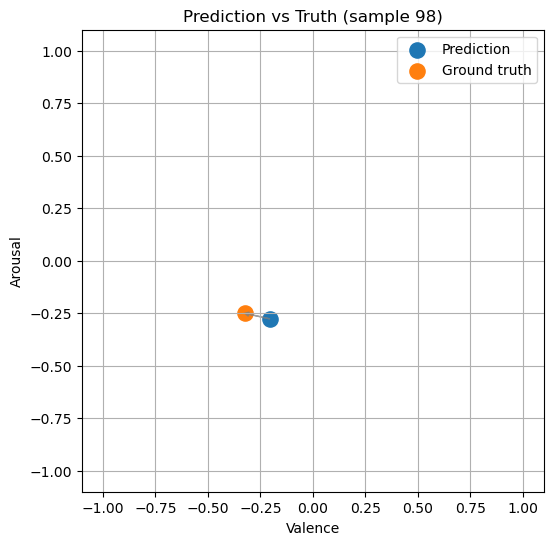

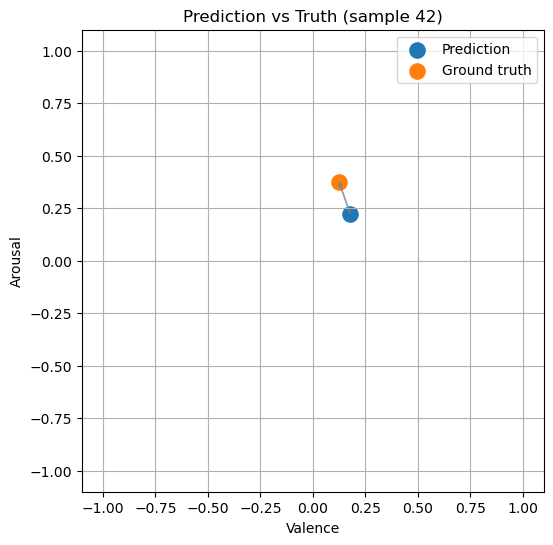

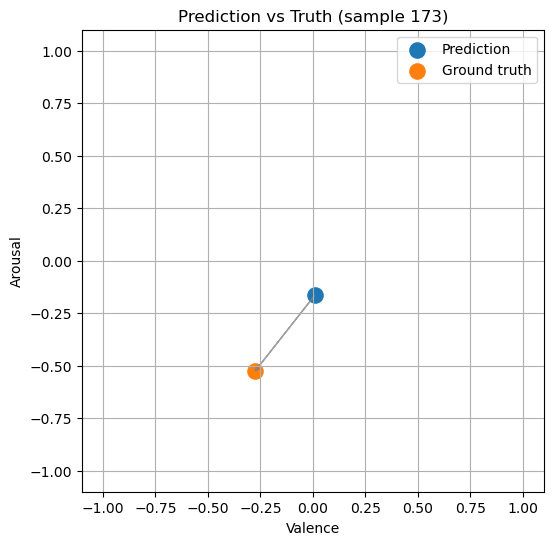

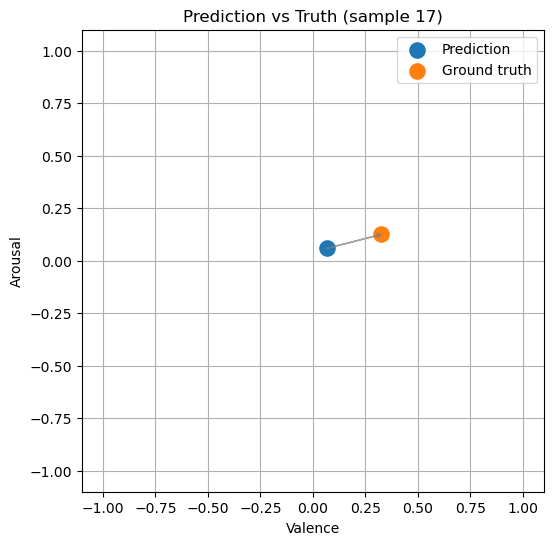

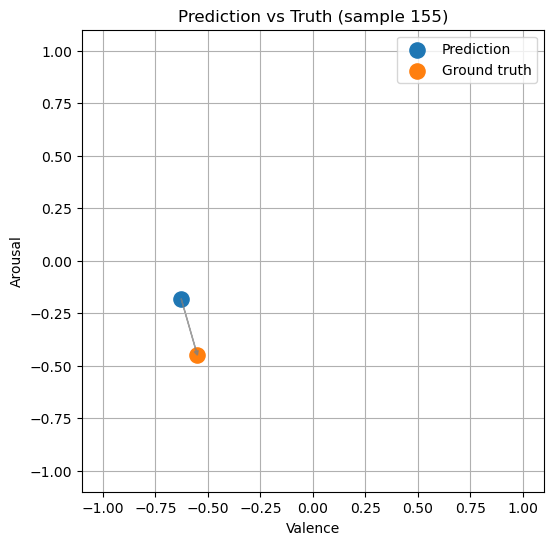

In [18]:
results = full_monty()

In [19]:
print(results[2])

{3: {'valence_pred': tensor([-1.6714e-01,  1.1257e-01,  4.8572e-02,  7.2611e-02,  2.2720e-03,
         1.9734e-01,  3.0608e-01, -6.4578e-02, -2.4816e-01, -3.6951e-01,
        -5.1062e-01, -3.0666e-01,  2.4976e-01, -4.2164e-01,  3.0149e-01,
         7.2302e-02, -1.7735e-01, -3.9953e-01,  1.4320e-01,  4.0677e-02,
        -1.1388e-01, -1.0954e-01, -7.6643e-02, -1.8298e-01,  1.6235e-01,
        -2.8437e-01, -1.3163e-01, -3.8548e-01, -6.7001e-01,  1.5624e-01,
        -5.8422e-01,  2.0128e-01,  1.5269e-01, -6.7549e-02,  1.6673e-01,
         3.1018e-01, -5.5690e-01,  9.5507e-02,  1.4255e-02, -1.0288e-01,
         1.0310e-01,  8.3038e-02,  2.1705e-02,  6.7032e-02, -1.4906e-01,
         2.5828e-01, -5.6068e-02,  2.0278e-01,  2.8436e-02, -4.4103e-02,
         1.2285e-02,  5.7256e-02,  1.4774e-02,  1.1259e-01,  2.3900e-01,
         2.2497e-01,  2.6827e-01,  1.9019e-01,  3.0102e-02,  1.8654e-01,
        -7.3902e-02,  9.7459e-02, -5.9741e-02,  1.3079e-01,  1.5224e-01,
        -1.1571e-03, -4.3977e-